# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

## Import Libraries

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from ipywidgets import FloatProgress

In [2]:
# Training settings
batch_size = 256
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## Load Data

In [4]:
dataset = 'cifar10'
train_dir = f'data/{dataset}/train'
test_dir = f'data/{dataset}/test'

In [5]:
size = 32
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [7]:
trainset  = datasets.CIFAR10(root=train_dir, train=True, transform=transform_train, download=True)
testset  = datasets.CIFAR10(root=test_dir, train=False, transform=transform_test, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=8)

## Random Plots

In [ ]:
trainset_raw  = datasets.CIFAR10(root="data/cifar10/raw/train", train=True, download=True)

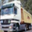

In [64]:
trainset_raw[1][0]

## Effecient Attention

### Linformer

In [22]:
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )

### Visual Transformer

In [10]:
from vit_pytorch import ViT

model = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

# img = torch.randn(1, 3, 256, 256)

# preds = v(img) # (1, 1000)

In [23]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    # transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
